In [1]:
#play around with insightface model.
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from lfw import gen_all_pic_labels
from sklearn.cluster import DBSCAN
from insightface.data import get_image as ins_get_image
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
from deepface import DeepFace
import arcface_align

2021-11-28 22:16:10.832891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mafffia/anaconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-28 22:16:10.832912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load in of the pics-files pairs
## In this notebook, I'm trying to clustering gender info.

In [5]:
pics,names,genders = gen_all_pic_labels('./lfw_funneled/')
#prepare gender
df = pd.DataFrame({'files':pics,'name':names,'gender':genders})

In [6]:
len(genders)

13233

In [7]:
#namely we have 5749 different faces
print(df.head)

<bound method NDFrame.head of                                                    files            name  \
0      ./lfw_funneled/Dennis_Powell/Dennis_Powell_000...   Dennis_Powell   
1      ./lfw_funneled/Dennis_Powell/Dennis_Powell_000...   Dennis_Powell   
2      ./lfw_funneled/Jaymon_Crabb/Jaymon_Crabb_0001.jpg    Jaymon_Crabb   
3      ./lfw_funneled/Henning_Scherf/Henning_Scherf_0...  Henning_Scherf   
4      ./lfw_funneled/Kellie_Coffey/Kellie_Coffey_000...   Kellie_Coffey   
...                                                  ...             ...   
13228  ./lfw_funneled/Hatsui_Hasuike/Hatsui_Hasuike_0...  Hatsui_Hasuike   
13229  ./lfw_funneled/John_Marburger/John_Marburger_0...  John_Marburger   
13230        ./lfw_funneled/Mark_Leno/Mark_Leno_0001.jpg       Mark_Leno   
13231    ./lfw_funneled/Troy_Hudson/Troy_Hudson_0001.jpg     Troy_Hudson   
13232  ./lfw_funneled/Camille_Colvin/Camille_Colvin_0...  Camille_Colvin   

       gender  
0        male  
1        male  
2        

In [8]:
df.gender.value_counts()

male      10271
female     2962
Name: gender, dtype: int64

## We can see that, the number of males are much higher than females, so far we don't do filter, but to see if the clustering algroithm could
## find the inner density un-match

In [27]:
males = df[df.gender=='male']

In [28]:
females = df[df.gender=='female']

In [29]:
num = 100

In [41]:
df_red = pd.concat([males[:num],females[:num]])

In [43]:
df = df_red

In [44]:
df = df.reset_index()

### Test of embedding

In [10]:
face_img = arcface_align.get_face_align('./lfw_funneled/Yoriko_Kawaguchi/Yoriko_Kawaguchi_0003.jpg')
rep = DeepFace.represent(face_img, model_name = 'ArcFace', model = None, enforce_detection = True, detector_backend = 'skip', align = False, normalization = 'base')

2021-11-28 22:16:38.520409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 22:16:38.520803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mafffia/anaconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-28 22:16:38.520844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mafffia/anaconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-28 22:16:38.520877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libc

In [11]:
len(rep)

512

In [48]:
male_total = 0
female_total = 0
male_correct = 0
female_correct = 0
gender_label = []

In [49]:
embs = np.zeros((num*2,512))

In [50]:
# pca = PCA(n_components=50)
# newX = pca.fit_transform(X) 
no = 0
for i in range(num*2):
    pic = df.loc[i]['files']
    name = df.loc[i]['name']
    gender = df.loc[i]['gender']
    gender_label.append(gender)
    print(pic,name,gender)
    
    try:
        face_img = arcface_align.get_face_align(pic)
    
        emb = DeepFace.represent(face_img, model_name = 'ArcFace', model = None, enforce_detection = True, detector_backend = 'skip', align = False, normalization = 'base')
        embs[i,:] = emb
    except:
        no+=1
        print('no :',no)
        embs[i,:] = np.zeros(512)

./lfw_funneled/Dennis_Powell/Dennis_Powell_0002.jpg Dennis_Powell male
./lfw_funneled/Dennis_Powell/Dennis_Powell_0001.jpg Dennis_Powell male
./lfw_funneled/Jaymon_Crabb/Jaymon_Crabb_0001.jpg Jaymon_Crabb male
./lfw_funneled/Henning_Scherf/Henning_Scherf_0001.jpg Henning_Scherf male
./lfw_funneled/Win_Aung/Win_Aung_0003.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0001.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0002.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0004.jpg Win_Aung male
./lfw_funneled/Dean_Barker/Dean_Barker_0001.jpg Dean_Barker male
./lfw_funneled/Mel_Karmazin/Mel_Karmazin_0001.jpg Mel_Karmazin male
./lfw_funneled/Celso_Lafer/Celso_Lafer_0001.jpg Celso_Lafer male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0002.jpg Nelson_Mandela male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0004.jpg Nelson_Mandela male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0001.jpg Nelson_Mandela male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0003.jpg Nelson_Mandela mal

In [51]:
no

0

In [54]:
embs

array([[ 0.0508105 , -0.06304078, -0.07458716, ...,  0.15387659,
         0.06173976,  0.10428791],
       [ 0.05966718,  0.35221863,  0.1406661 , ...,  0.16473256,
         0.07804877,  0.26810727],
       [-0.08179144,  0.06399854,  0.05289726, ...,  0.05610558,
         0.03828787,  0.15490347],
       ...,
       [ 0.04296884, -0.14625895,  0.20428914, ..., -0.05654222,
         0.00404851,  0.17269853],
       [-0.06820219,  0.03829949, -0.18034717, ...,  0.21922491,
        -0.10915494, -0.21102053],
       [-0.01849743,  0.38731533, -0.24278793, ...,  0.05889621,
        -0.00113503, -0.16500574]])

## Cluster with T-sne

In [17]:

face_umap = TSNE(n_components=2).fit_transform(embs)
scan = DBSCAN(min_samples=2,eps=25).fit(face_umap)
# scan = KMeans(n_clusters=2, random_state=0).fit(face_umap)
clustering = list(scan.labels_)

out_name = []
out_clu = []
out_gender = []
for i in range(len(clustering)):
    if(clustering[i]>=0):
        out_name.append(label[i])
        out_clu.append(clustering[i])
        out_gender.append(gender_label[i])
df_out = pd.DataFrame({'real':out_name,'cluster':out_clu,'gender':out_gender})
pd.set_option('display.max_columns',1000)
df_out = df_out.sort_values(by='cluster')
# print(df_out.sort_values(by='real'))
for i in df_out.index:
    print(df_out.loc[i]['cluster'] , '  ' , df_out.loc[i]['real'],'  ' , df_out.loc[i]['gender'] )
print('total clustered points :%d'%len(out_name))

NameError: name 'label' is not defined

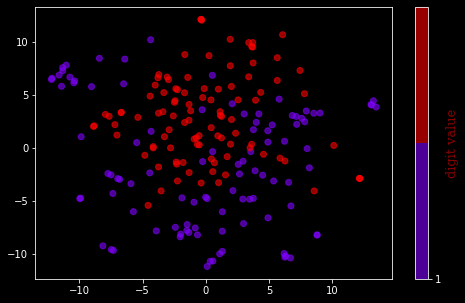

In [63]:
#pca = PCA(n_components=200, svd_solver='full')
#face_umap = pca.fit_transform(embs)
face_umap = TSNE(n_components=2).fit_transform(embs)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)


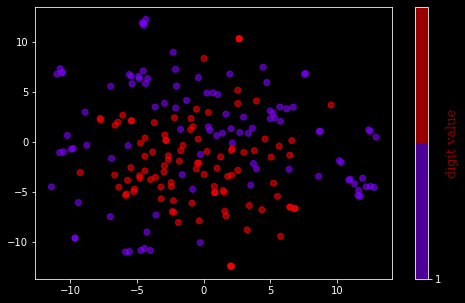

In [105]:
pca = PCA(n_components=100, svd_solver='full')
face_umap = pca.fit_transform(embs)
face_umap = TSNE(n_components=2).fit_transform(embs)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)


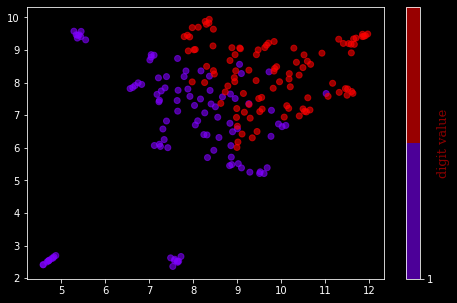

In [94]:
pca = PCA(n_components=20,svd_solver='full')
face_umap = pca.fit_transform(embs)
reducer = umap.UMAP(random_state=42,n_components=2)
face_umap = reducer.fit_transform(face_umap)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)


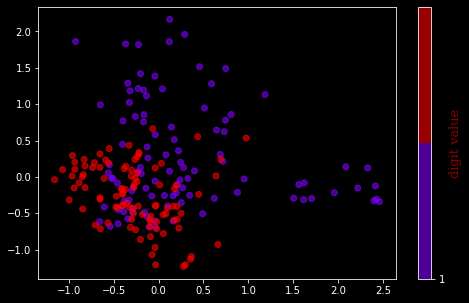

In [85]:
pca = PCA(n_components=2,svd_solver='full')
face_umap = pca.fit_transform(embs)
# reducer = umap.UMAP(random_state=42,n_components=2)
# face_umap = reducer.fit_transform(face_umap)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)

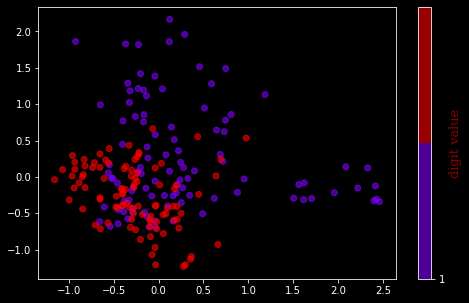

In [106]:
pca = PCA(n_components=2,svd_solver='full')
face_umap = pca.fit_transform(embs)


scan = OPTICS(min_samples=2,metric='cosine').fit(face_umap)
clustering = list(scan.labels_)

font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)

## Clustering with OPTICS

In [107]:
scan

OPTICS(metric='cosine', min_samples=2)